# Install dependencies

In [ ]:
!pip install pymc arviz pandas numpy matplotlib seaborn

# Load and normalize the resource dataset

In [ ]:
import pandas as pd
import numpy as np

# Load the labeled 13-hurricane dataset
df = pd.read_csv("/content/resource_dataset_with_id_category_storm_features.csv")

# List of hurricane features to normalize
in_features = [
    'maximum_sustained_wind_knots_max',
    'maximum_sustained_wind_knots_mean',
    'central_pressure_mb_min',
    'central_pressure_mb_mean',
    'radius_of_max_wind_nm_max',
    'radius_of_max_wind_nm_mean'
]

out_features = ['shelters', 'meals', 'water_gallons', 'fuel_gallons']
y_dict = {}

# Normalize with z-score
for col in in_features:
    df[f"{col}_norm"] = (df[col] - df[col].mean()) / df[col].std()

# Input features (X) and target (y)
X = df[[f"{col}_norm" for col in in_features]]

y = df[out_features[0]].values

for col in out_features:
  y_dict[col] = df[col].values

# Define and Sample from Bayesian Gamma Model

In [ ]:
import pymc as pm

# Set a flag to control whether we're training or predicting
is_training = True  # set to False when running prediction

pm_data_list = []
priors_list = []
with pm.Model() as model:
    # Declare inputs using pm.Data so we can override them later
    for col in in_features:
      pm_data_list.append(pm.Data(f"{col}_norm", X[f"{col}_norm"].values))

    # Priors
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=10)
    for col in in_features:
      priors_list.append(pm.Normal(f"beta_{col}", mu=0, sigma=2))

    # Linear model (log link for gamma)
    sum1 = intercept
    for i in range(len(in_features)):
      sum1 += pm_data_list[i] * priors_list[i]
    mu = pm.math.exp(sum1)

    for resource in out_features:
      print(f"Modeling for resource: {resource}")
      # Likelihood (only include observed data if training)
      if is_training:
          y_obs = pm.Gamma(f"y_obs_{resource}", mu=mu, sigma=sigma, observed=y_dict[resource])
      else:
          y_obs = pm.Gamma(f"y_obs_{resource}", mu=mu, sigma=sigma)

      # Sample posterior (only during training)
      if is_training:
          trace = pm.sample(3000, tune=1000, target_accept=0.95, return_inferencedata=True)
          import arviz as az
          print(f"Trace saved for resource: {resource}")
          az.to_netcdf(trace, f"{resource}_trace.nc")

Modeling for resource: shelters


Output()

Trace saved for resource: shelters
Modeling for resource: meals


Output()

Trace saved for resource: meals
Modeling for resource: water_gallons


Output()

Trace saved for resource: water_gallons
Modeling for resource: fuel_gallons


Output()

Trace saved for resource: fuel_gallons


# Load all saved traces into a dictionary

In [ ]:
import arviz as az

# List of hurricane features to normalize
in_features = [
    'maximum_sustained_wind_knots_max',
    'maximum_sustained_wind_knots_mean',
    'central_pressure_mb_min',
    'central_pressure_mb_mean',
    'radius_of_max_wind_nm_max',
    'radius_of_max_wind_nm_mean'
]

out_features = ['shelters', 'meals', 'water_gallons', 'fuel_gallons']

# Load saved traces from file
loaded_traces = {}
for resource in out_features:
    trace = az.from_netcdf(f"{resource}_trace.nc")
    loaded_traces[resource] = trace

# Summarize the Posterior Estimates

In [ ]:
for resource, trace in loaded_traces.items():
    print(f"\nPosterior Summary for: {resource}")
    display(az.summary(trace, kind="stats", round_to=2))


Posterior Summary for: shelters


,mean,sd,hdi_3%,hdi_97%
beta_central_pressure_mb_mean,1.44,0.80,-0.16,2.89
beta_central_pressure_mb_min,0.80,0.80,-0.83,2.24
beta_maximum_sustained_wind_knots_max,0.74,0.89,-0.90,2.46
beta_maximum_sustained_wind_knots_mean,2.03,0.96,0.22,3.82
beta_radius_of_max_wind_nm_max,-0.05,0.56,-1.24,0.97
beta_radius_of_max_wind_nm_mean,0.26,0.73,-1.16,1.65
intercept,3.54,0.28,3.06,4.10
sigma,33.18,6.71,20.78,45.12



Posterior Summary for: meals


,mean,sd,hdi_3%,hdi_97%
beta_central_pressure_mb_mean,1.88,0.54,0.87,2.90
beta_central_pressure_mb_min,-0.63,0.67,-1.93,0.56
beta_maximum_sustained_wind_knots_max,-1.23,0.83,-2.75,0.35
beta_maximum_sustained_wind_knots_mean,1.48,0.72,0.16,2.85
beta_radius_of_max_wind_nm_max,-0.99,0.59,-2.05,0.12
beta_radius_of_max_wind_nm_mean,0.21,0.64,-1.02,1.38
intercept,-4.84,0.24,-5.28,-4.37
sigma,72.46,7.08,57.96,85.00



Posterior Summary for: water_gallons


,mean,sd,hdi_3%,hdi_97%
beta_central_pressure_mb_mean,2.09,0.48,1.21,2.97
beta_central_pressure_mb_min,-0.73,0.58,-1.84,0.33
beta_maximum_sustained_wind_knots_max,-1.36,0.75,-2.76,0.05
beta_maximum_sustained_wind_knots_mean,1.70,0.64,0.52,2.88
beta_radius_of_max_wind_nm_max,-0.95,0.52,-1.91,0.04
beta_radius_of_max_wind_nm_mean,0.14,0.56,-0.95,1.15
intercept,-4.30,0.20,-4.69,-3.95
sigma,88.76,7.10,75.64,102.00



Posterior Summary for: fuel_gallons


,mean,sd,hdi_3%,hdi_97%
beta_central_pressure_mb_mean,2.00,0.43,1.19,2.78
beta_central_pressure_mb_min,-0.67,0.52,-1.61,0.32
beta_maximum_sustained_wind_knots_max,-1.16,0.65,-2.38,0.01
beta_maximum_sustained_wind_knots_mean,1.60,0.57,0.60,2.73
beta_radius_of_max_wind_nm_max,-1.10,0.43,-1.92,-0.31
beta_radius_of_max_wind_nm_mean,0.35,0.46,-0.50,1.23
intercept,-3.79,0.17,-4.11,-3.48
sigma,102.33,7.02,89.20,115.48


# Plot Trace for Each Parameter


Sampling Trace for: shelters


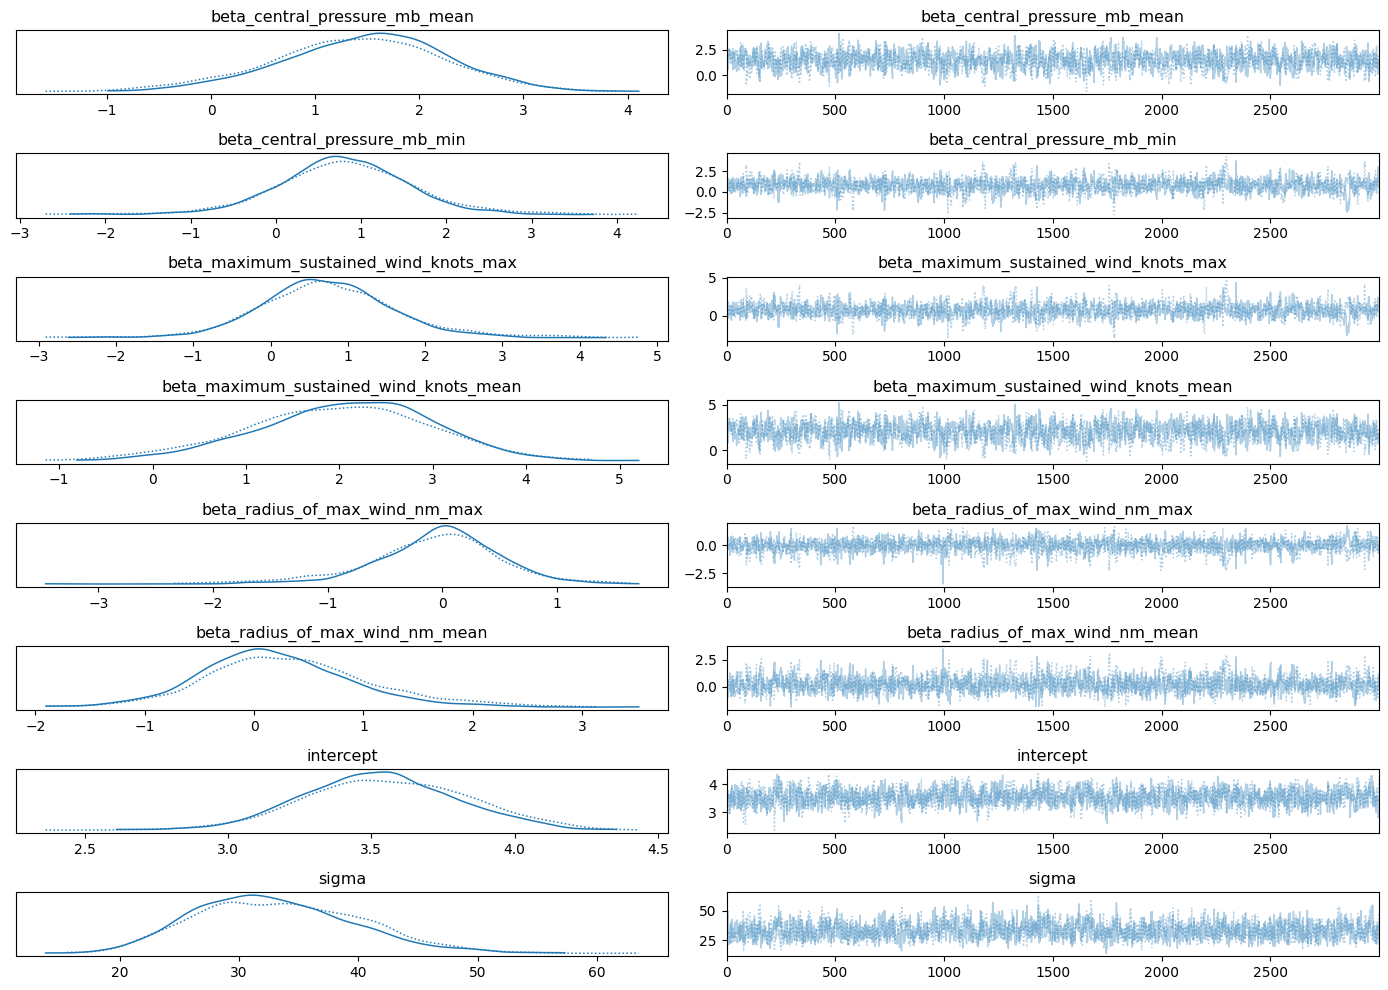


Sampling Trace for: meals


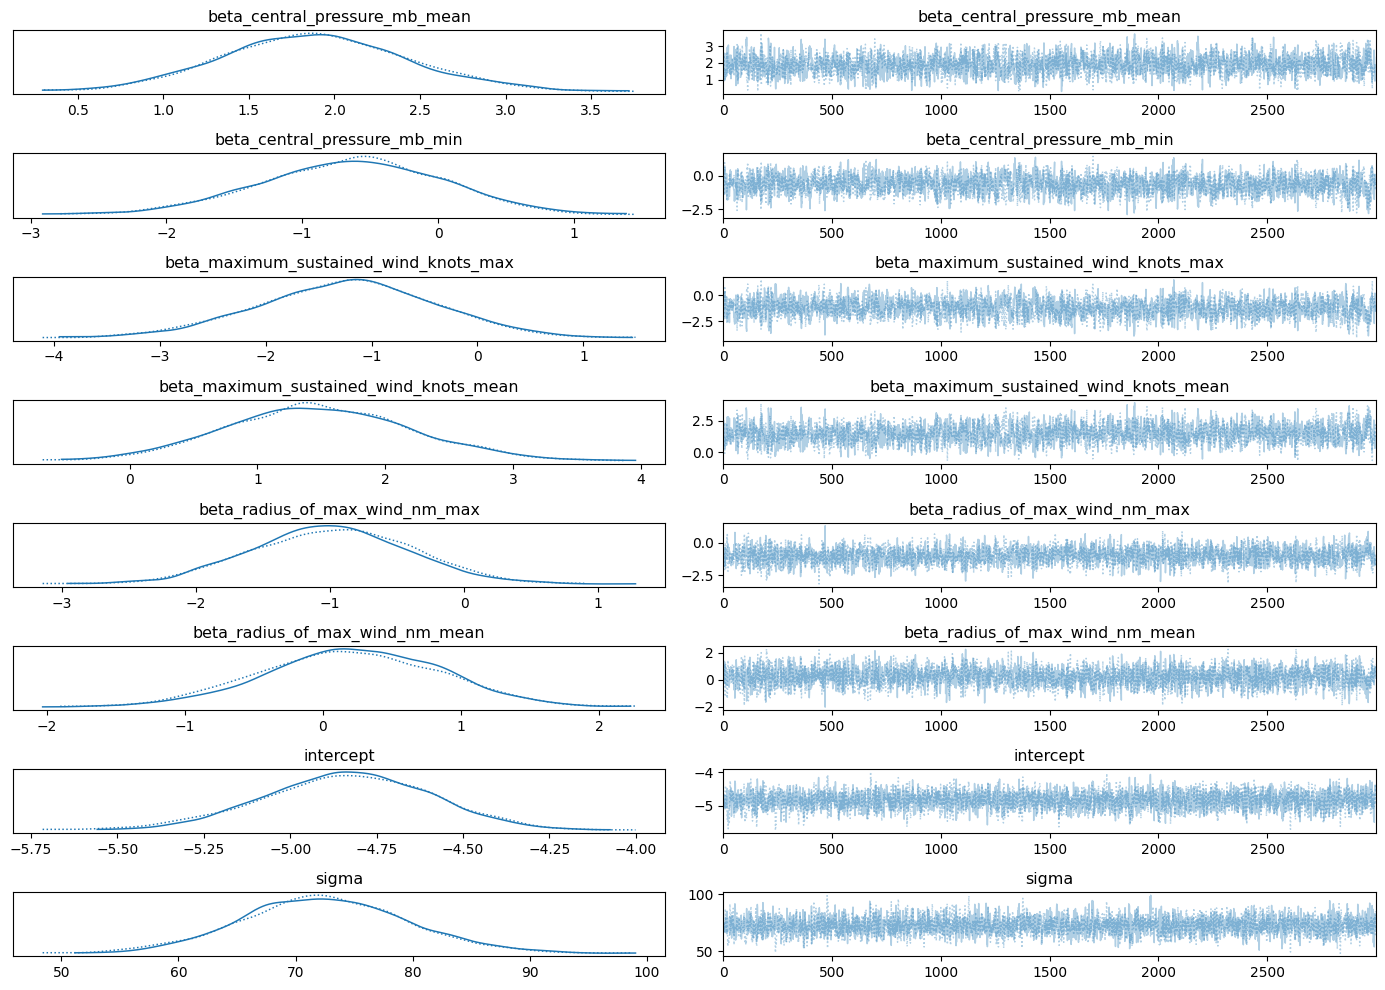


Sampling Trace for: water_gallons


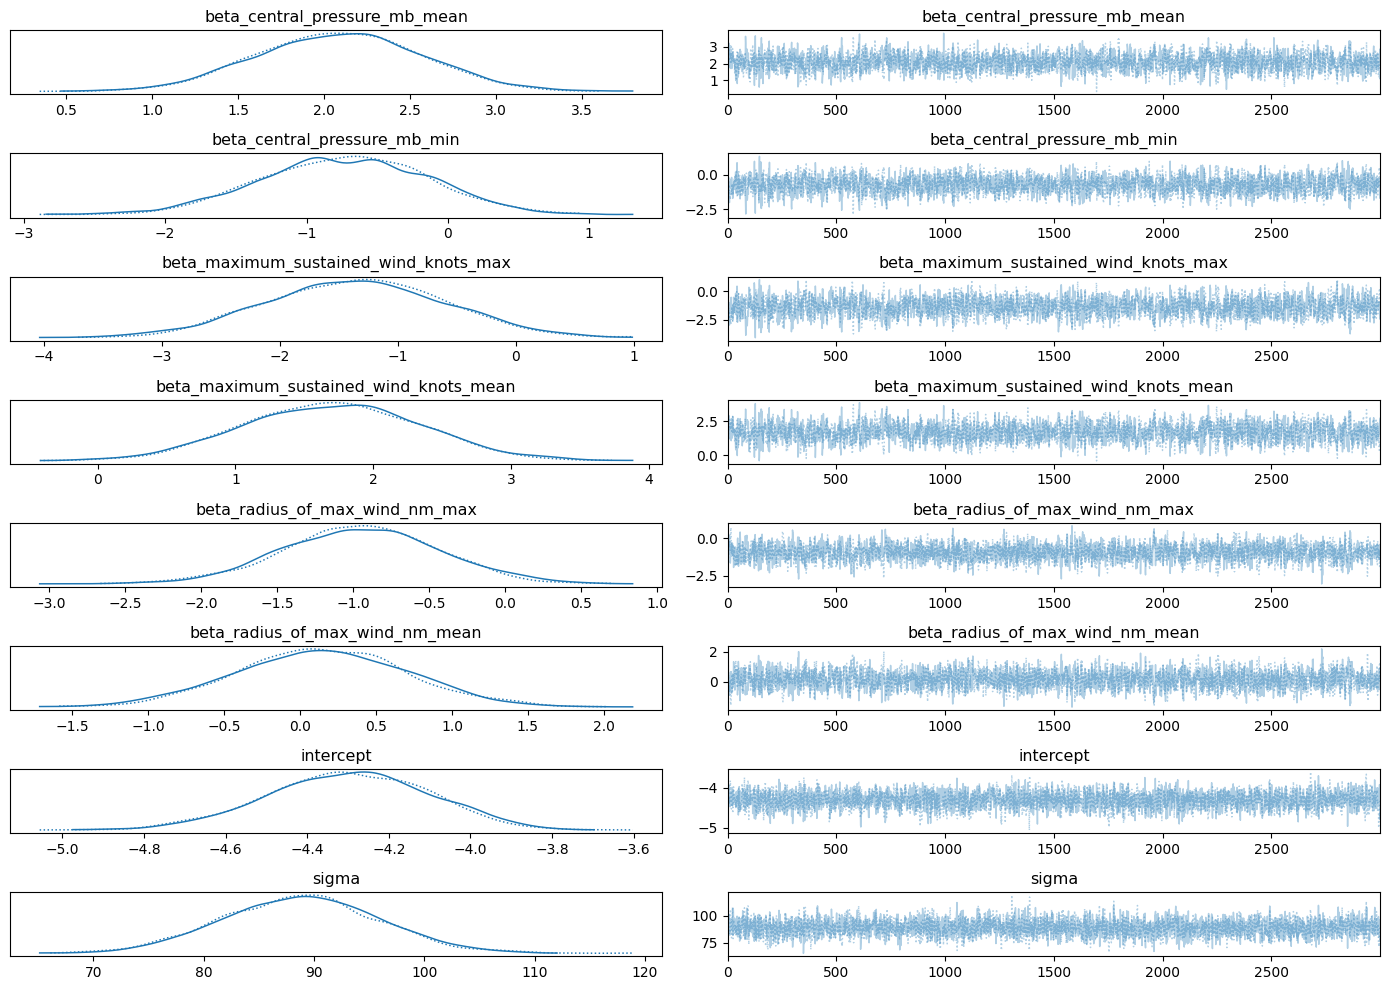


Sampling Trace for: fuel_gallons


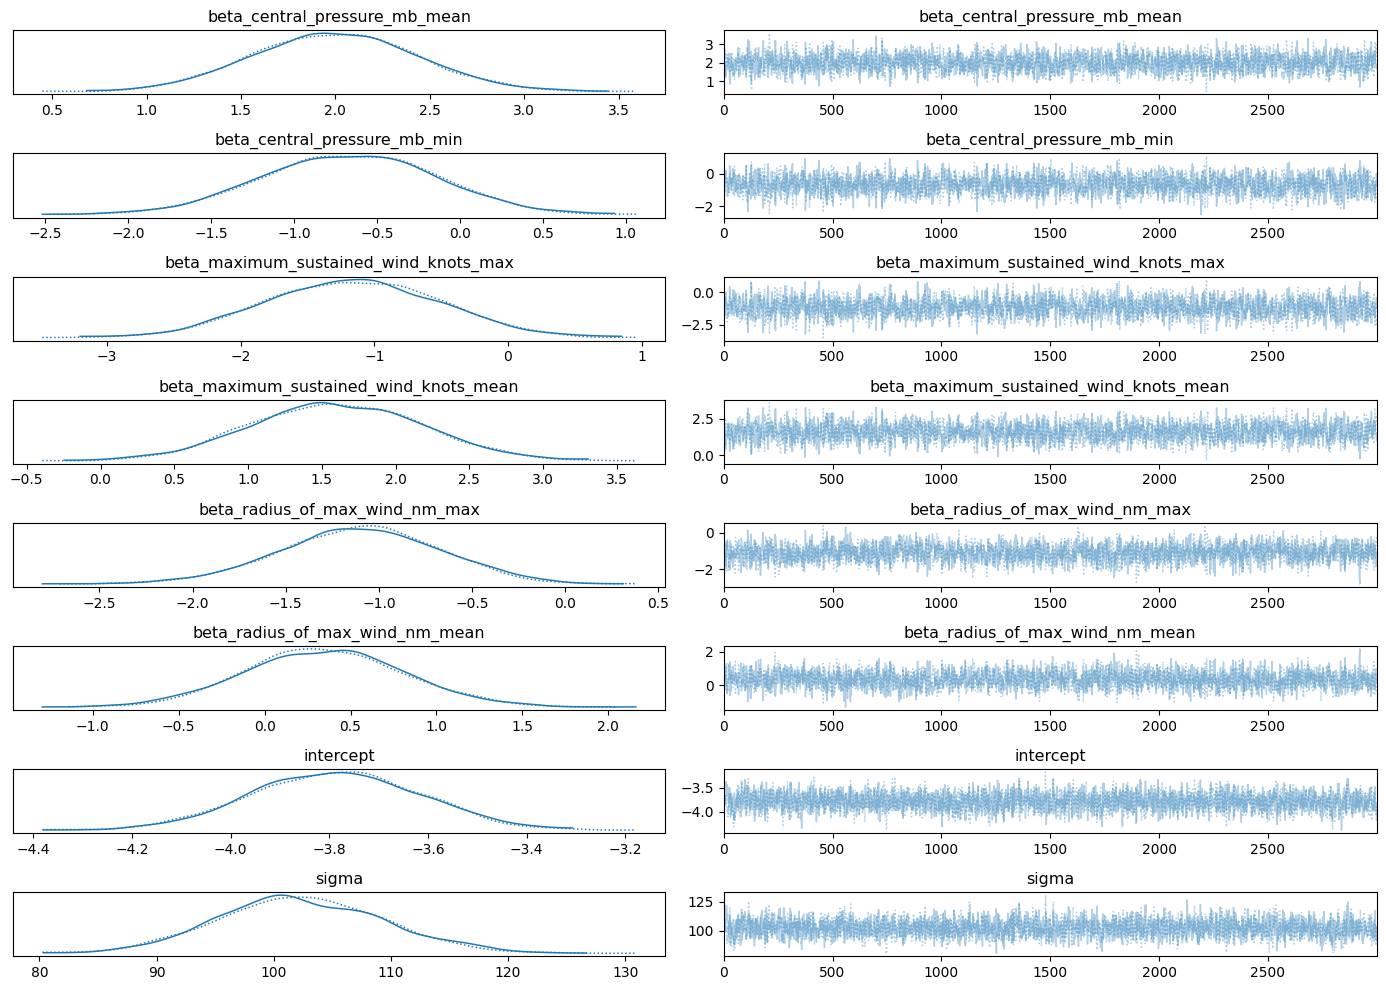

In [ ]:
import matplotlib.pyplot as plt
import arviz as az

for resource, trace in loaded_traces.items():
    print(f"\nSampling Trace for: {resource}")
    az.plot_trace(trace, figsize=(14, 10))
    plt.tight_layout()
    plt.show()

# Generate Shelter Predictions for the Rest Hurricanes

In [ ]:
import pymc as pm
import arviz as az

# Set mode to prediction
is_training = False

pm_data_list = []
priors_list = []
with pm.Model() as model:
    # Declare inputs using pm.Data so we can override them later
    for col in in_features:
      pm_data_list.append(pm.Data(f"{col}_norm", X[f"{col}_norm"].values))

    # Priors
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=10)
    for col in in_features:
      priors_list.append(pm.Normal(f"beta_{col}", mu=0, sigma=2))

    # Linear model (log link for gamma)
    sum1 = intercept
    for i in range(len(in_features)):
      sum1 += pm_data_list[i] * priors_list[i]
    mu = pm.math.exp(sum1)

    for resource in out_features:
      # Predictive distribution only (no observed y)
      y_obs = pm.Gamma(f"y_obs_{resource}", mu=mu, sigma=sigma)

In [ ]:
# Load the hurricane dataset to predict on
df_pred = pd.read_csv("hurdat2_grouped.csv")

posterior_predictive_dict = {}
# Normalize using the training dataset's mean and std
for col in in_features:
    mean = df[col].mean()
    std = df[col].std()
    df_pred[f"{col}_norm"] = (df_pred[col] - mean) / std

# Set new data into the model
data_dict = {}
with model:
    for col in in_features:
      data_dict[f"{col}_norm"] = df_pred[f"{col}_norm"].values

    pm.set_data(data_dict)

    # Generate predictions from the posterior
    for resource in out_features:
      posterior_predictive_dict[resource] = pm.sample_posterior_predictive(loaded_traces[resource], var_names=[f"y_obs_{resource}"])

Output()

Output()

Output()

Output()

In [ ]:
for resourcce in out_features:
  print(f"Shape for {resource}:")
  posterior_predictive = posterior_predictive_dict[resource]
  print(posterior_predictive.posterior_predictive[f"y_obs_{resource}"].shape)

Shape for fuel_gallons:
(2, 3000, 72)
Shape for fuel_gallons:
(2, 3000, 72)
Shape for fuel_gallons:
(2, 3000, 72)
Shape for fuel_gallons:
(2, 3000, 72)


In [ ]:
import numpy as np
import pandas as pd

summary_dict = {}

for resource in out_features:
    # Access y_obs_{resource} from .posterior_predictive group
    y_samples = posterior_predictive_dict[resource].posterior_predictive[f"y_obs_{resource}"].values
    y_samples = y_samples.reshape(-1, y_samples.shape[-1])  # (6000, num_hurricanes)

    # Compute stats
    mean_preds = y_samples.mean(axis=0)
    lower_bound = np.percentile(y_samples, 2.5, axis=0)
    upper_bound = np.percentile(y_samples, 97.5, axis=0)

    # Save summary DataFrame
    summary_df = pd.DataFrame({
        "mean_prediction": mean_preds,
        "lower_95_CI": lower_bound,
        "upper_95_CI": upper_bound
    })

    summary_dict[resource] = summary_df

    print(f"Summary for {resourcce}:")
    display(summary_df.head())

Summary for fuel_gallons:


,mean_prediction,lower_95_CI,upper_95_CI
0,34.248593,4.008545e-04,129.134526
1,16.131169,4.804913e-38,120.293533
2,17.777263,0.000000e+00,149.262967
3,71.010276,3.862435e+00,194.617484
4,33.105234,8.858188e-13,133.861999


Summary for fuel_gallons:


,mean_prediction,lower_95_CI,upper_95_CI
0,1.702500e-02,0.0,0.0
1,0.000000e+00,0.0,0.0
2,0.000000e+00,0.0,0.0
3,0.000000e+00,0.0,0.0
4,4.698168e-67,0.0,0.0


Summary for fuel_gallons:


,mean_prediction,lower_95_CI,upper_95_CI
0,1.787734e-01,0.0,0.0
1,0.000000e+00,0.0,0.0
2,1.178889e-228,0.0,0.0
3,0.000000e+00,0.0,0.0
4,3.221573e-188,0.0,0.0


Summary for fuel_gallons:


,mean_prediction,lower_95_CI,upper_95_CI
0,3.830594e-02,0.0,0.0
1,0.000000e+00,0.0,0.0
2,0.000000e+00,0.0,0.0
3,6.791470e-116,0.0,0.0
4,1.659590e-11,0.0,0.0


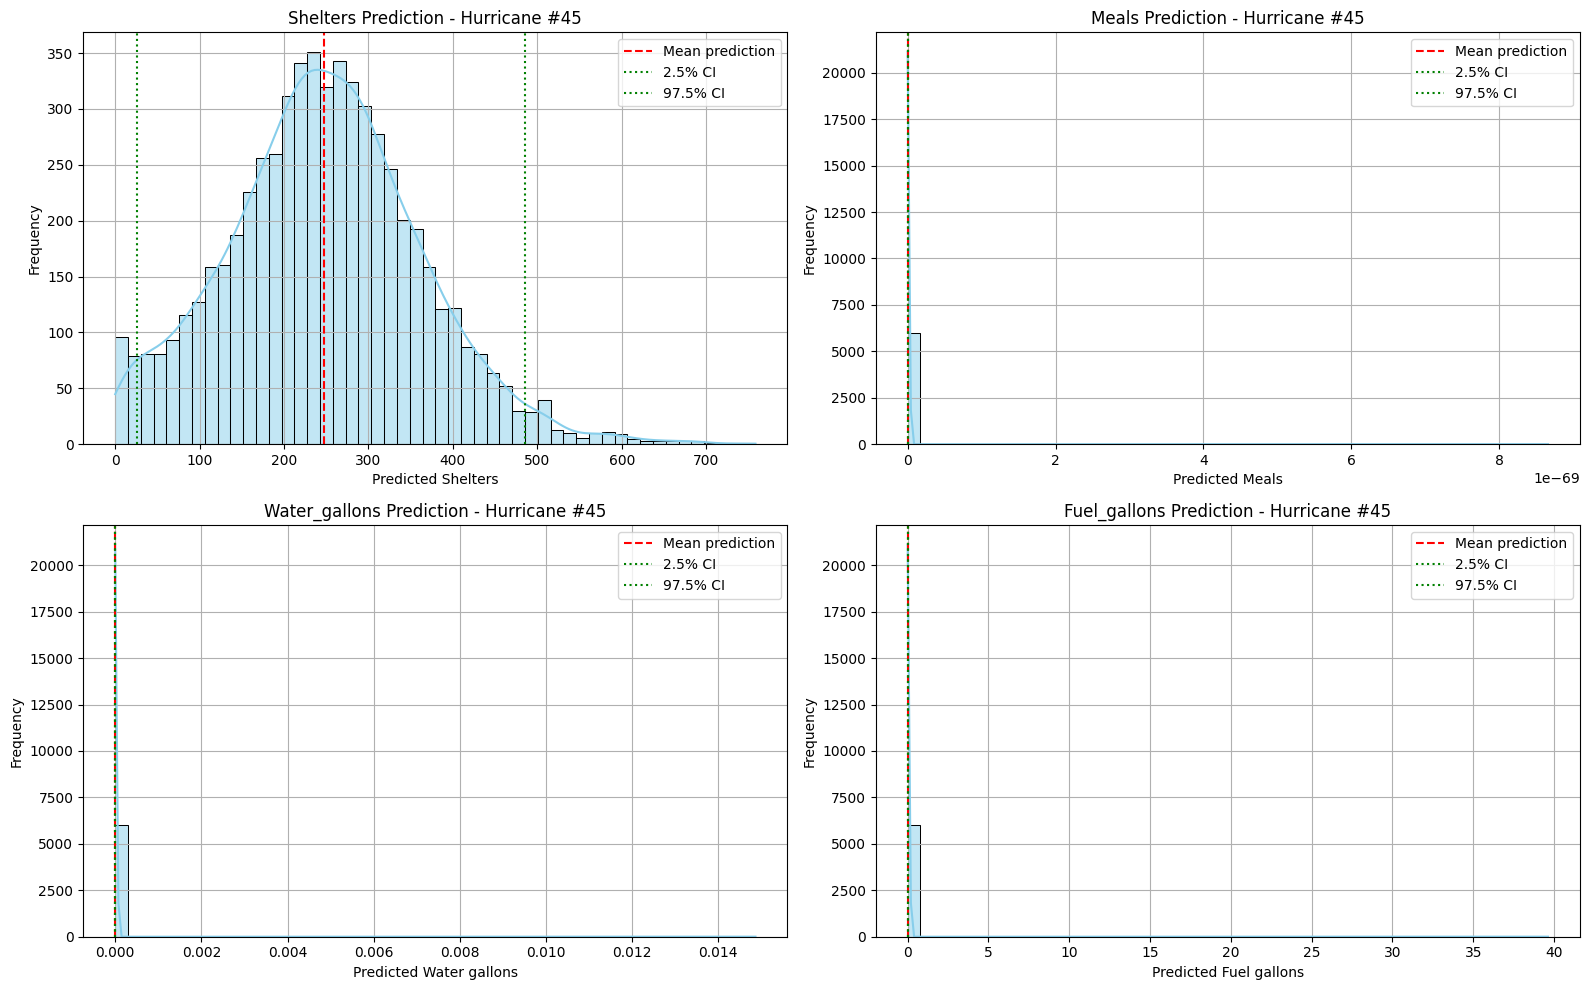

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np  # Ensure numpy is imported

# Hurricane index to visualize
idx = 45  # change as needed

# Plot settings
plt.figure(figsize=(16, 10))
for i, resource in enumerate(out_features):
    # Extract samples for the given hurricane
    y_samples = posterior_predictive_dict[resource].posterior_predictive[f"y_obs_{resource}"].values
    y_samples = y_samples.reshape(-1, y_samples.shape[-1])
    hurricane_preds = y_samples[:, idx]

    # Plot
    plt.subplot(2, 2, i + 1)
    sns.histplot(hurricane_preds, bins=50, kde=True, color="skyblue")
    plt.axvline(np.mean(hurricane_preds), color='red', linestyle='--', label='Mean prediction')
    plt.axvline(np.percentile(hurricane_preds, 2.5), color='green', linestyle=':', label='2.5% CI')
    plt.axvline(np.percentile(hurricane_preds, 97.5), color='green', linestyle=':', label='97.5% CI')
    plt.title(f"{resource.capitalize()} Prediction - Hurricane #{idx}")
    plt.xlabel(f"Predicted {resource.replace('_', ' ').capitalize()}")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
df[out_features].describe()

,shelters,meals,water_gallons,fuel_gallons
count,13.000000,1.300000e+01,1.300000e+01,1.300000e+01
mean,150.307692,4.373077e+06,1.666154e+06,3.161538e+05
std,161.958011,6.063505e+06,2.240419e+06,4.169440e+05
min,5.000000,5.000000e+04,1.000000e+04,5.000000e+04
25%,30.000000,5.000000e+05,3.000000e+05,1.000000e+05
50%,100.000000,2.000000e+06,7.000000e+05,1.000000e+05
75%,250.000000,4.000000e+06,1.500000e+06,2.000000e+05
max,585.000000,1.900000e+07,6.700000e+06,1.400000e+06


In [ ]:
# Extract posterior predictive samples for shelters
shelter_samples = posterior_predictive_dict["shelters"].posterior_predictive["y_obs_shelters"].values
shelter_samples = shelter_samples.reshape(-1, shelter_samples.shape[-1])  # shape: (6000, 72)

# Transpose to get shape: (72 hurricanes, 6000 model predictions)
shelter_samples_t = shelter_samples.T

# Generate column names model1, model2, ..., model6000
model_columns = [f"model{i+1}" for i in range(shelter_samples_t.shape[1])]

# Create DataFrame from transposed predictions
shelter_model_df = pd.DataFrame(shelter_samples_t, columns=model_columns)

# Combine with original hurricane data (preserving all columns from hurdat2 grouped)
final_shelter_df = pd.concat([df_pred.reset_index(drop=True), shelter_model_df], axis=1)

# Save to CSV
final_shelter_df.to_csv("hurdat2_bayesian_inference_shelters.csv", index=False)

print("Bayesian inference shelters saved with original features and 6000 model predictions per hurricane.")

Bayesian inference shelters saved with original features and 6000 model predictions per hurricane.
